In [1]:
import seaborn as sns
from rich import print, inspect, traceback, pretty
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps as cmaps

import cartopy.crs as ccrs

from chaotic_carbon_networks import ROOT
from chaotic_carbon_networks import matrix as ccnm
from chaotic_carbon_networks.preprocessing import concat_airs_data, concat_graced_data, preprocess_graced_data
from chaotic_carbon_networks.viz import plot_world, plot_matrix, plot_world_to_axis
from chaotic_carbon_networks.anomaly_correction import anomaly_correction_month, anomaly_correction_week
from chaotic_carbon_networks.hex import hexgrid, filledgrid_from_hexgrid
from chaotic_carbon_networks.masks import mask_population, mask_poles
from chaotic_carbon_networks.analysis import double_dataset, single_dataset
from chaotic_carbon_networks.matrix import (
    laged_pearson_similarity_matrix,
    mutual_information_matrix,
    adjacency_matrix,
    link_lengths_like,
    degrees,
    average_link_length,
    betweenness
)

FIGURE_PATH = ROOT / "figures" / "paper"
FIGURE_PATH.mkdir(parents=True, exist_ok=True)

sns.set_theme(context='paper', style="whitegrid", palette="Set2", font_scale=1.5, rc={'figure.figsize':(9,6)})
pretty.install()
traceback.install(show_locals=False)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fd7a41e8810>>

## Hex vs NoHex

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

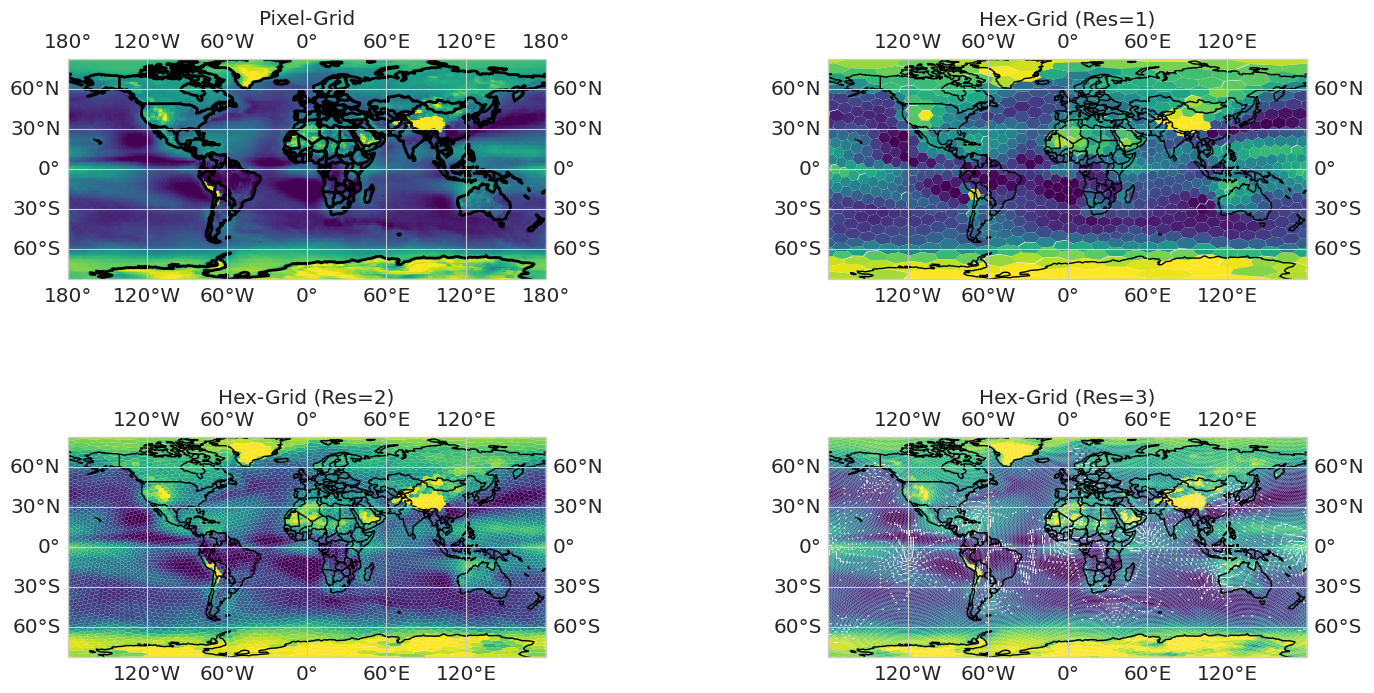

In [2]:
co2 = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_hex = hexgrid(co2, hex_res=1)
co2_hex2 = hexgrid(co2, hex_res=2)
co2_hex3 = hexgrid(co2, hex_res=3)

fig, axs = plt.subplots(2, 2,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(18, 9))
axs = axs.flatten()
plot_world_to_axis(co2.mean("time", keep_attrs=True), ax=axs[0])
plot_world_to_axis(co2_hex.mean("time", keep_attrs=True), ax=axs[1])
plot_world_to_axis(co2_hex2.mean("time", keep_attrs=True), ax=axs[2])
plot_world_to_axis(co2_hex3.mean("time", keep_attrs=True), ax=axs[3])
axs[0].set_title("Pixel-Grid")
axs[1].set_title("Hex-Grid (Res=1)")
axs[2].set_title("Hex-Grid (Res=2)")
axs[3].set_title("Hex-Grid (Res=3)")
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])

fig.savefig(FIGURE_PATH / "hex-vs-nonhex.svg")
fig.savefig(FIGURE_PATH / "hex-vs-nonhex.jpg")

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

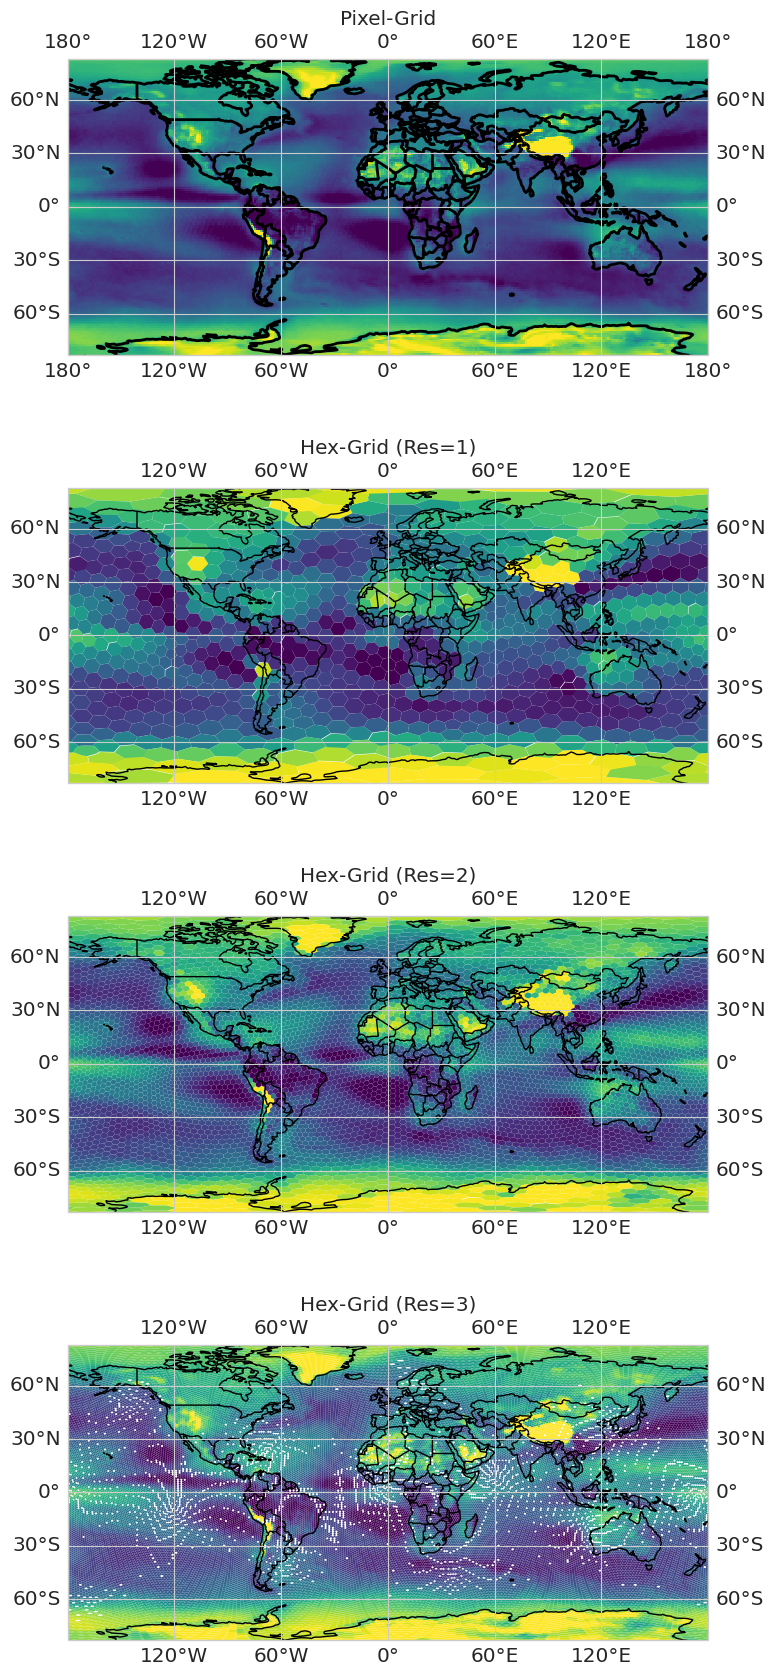

In [3]:
co2 = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_hex = hexgrid(co2, hex_res=1)
co2_hex2 = hexgrid(co2, hex_res=2)
co2_hex3 = hexgrid(co2, hex_res=3)

fig, axs = plt.subplots(4, 1,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(9, 18))
axs = axs.flatten()
plot_world_to_axis(co2.mean("time", keep_attrs=True), ax=axs[0])
plot_world_to_axis(co2_hex.mean("time", keep_attrs=True), ax=axs[1])
plot_world_to_axis(co2_hex2.mean("time", keep_attrs=True), ax=axs[2])
plot_world_to_axis(co2_hex3.mean("time", keep_attrs=True), ax=axs[3])
axs[0].set_title("Pixel-Grid")
axs[1].set_title("Hex-Grid (Res=1)")
axs[2].set_title("Hex-Grid (Res=2)")
axs[3].set_title("Hex-Grid (Res=3)")
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])

fig.tight_layout()

fig.savefig(FIGURE_PATH / "hex-vs-nonhex-col.svg")
fig.savefig(FIGURE_PATH / "hex-vs-nonhex-col.jpg")

In [4]:
del co2, co2_hex, co2_hex2, co2_hex3, fig, axs

## Over Time

In [63]:
co2_graced = preprocess_graced_data(hex_res=3)
co2_graced = co2_graced.resample(time='1MS').sum(dim='time').dropna("time", how="all")
co2_graced = (co2_graced - co2_graced.mean(dim="time")) / co2_graced.std(dim="time")
co2_graced.attrs = {"long_name": "Z-Normalized Human CO2 Emissions", "units": "kgC"}

co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
attrs = co2_airs.attrs.copy()
co2_airs = co2_airs.diff("time")
co2_airs.attrs = attrs
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)
co2_airs = (co2_airs - co2_airs.mean(dim="time")) / co2_airs.std(dim="time")
co2_airs.attrs = attrs
co2_airs = co2_airs.sel(time=co2_graced.time, method="nearest")

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/preprocessed_res3.nc

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

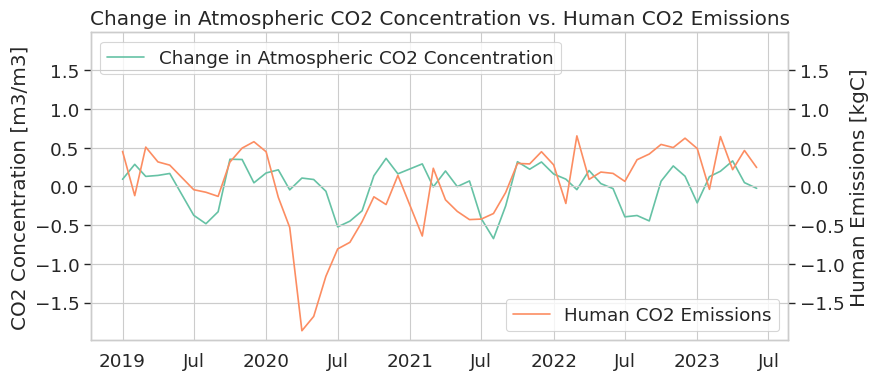

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax2 = ax.twinx()
palette = sns.color_palette("Set2", 2)

co2_airs.mean(dim="vertex").plot(ax=ax, label="Change in Atmospheric CO2 Concentration", c=palette[0])
(co2_graced.mean(dim="vertex")).plot(ax=ax2, label="Human CO2 Emissions", c=palette[1])
ax.legend(loc="upper left")
ax2.legend(loc="lower right")

# Center the y-axis to 0
ymin, ymax = ax2.get_ylim()
ymin = min(ymin, -ymax)
ymax = max(ymax, -ymin)
ax.set_ylim(-ymax, ymax)
ax2.set_ylim(-ymax, ymax)


ax.set_title("Change in Atmospheric CO2 Concentration vs. Human CO2 Emissions")
ax2.set_title("")

ax.set_ylabel("CO2 Concentration [m3/m3]")
ax2.set_ylabel("Human Emissions [kgC]")
ax.set_xlabel("")
ax2.set_xlabel("")

fig.savefig(FIGURE_PATH / "over-time-alt.svg")

## Emissions -> Concentration Network

In [64]:
m = mutual_information_matrix(co2_graced, co2_airs)

In [65]:
a = adjacency_matrix(m, rr=0.01)
ll = link_lengths_like(a)
avgll_graced = average_link_length(a, ll)
deg_graced = degrees(a)
avgll_airs = average_link_length(a, ll, dim="vertex")
deg_airs = degrees(a, dim="vertex")

Using a threshold of 2.197087287902832 for the adjacency matrix

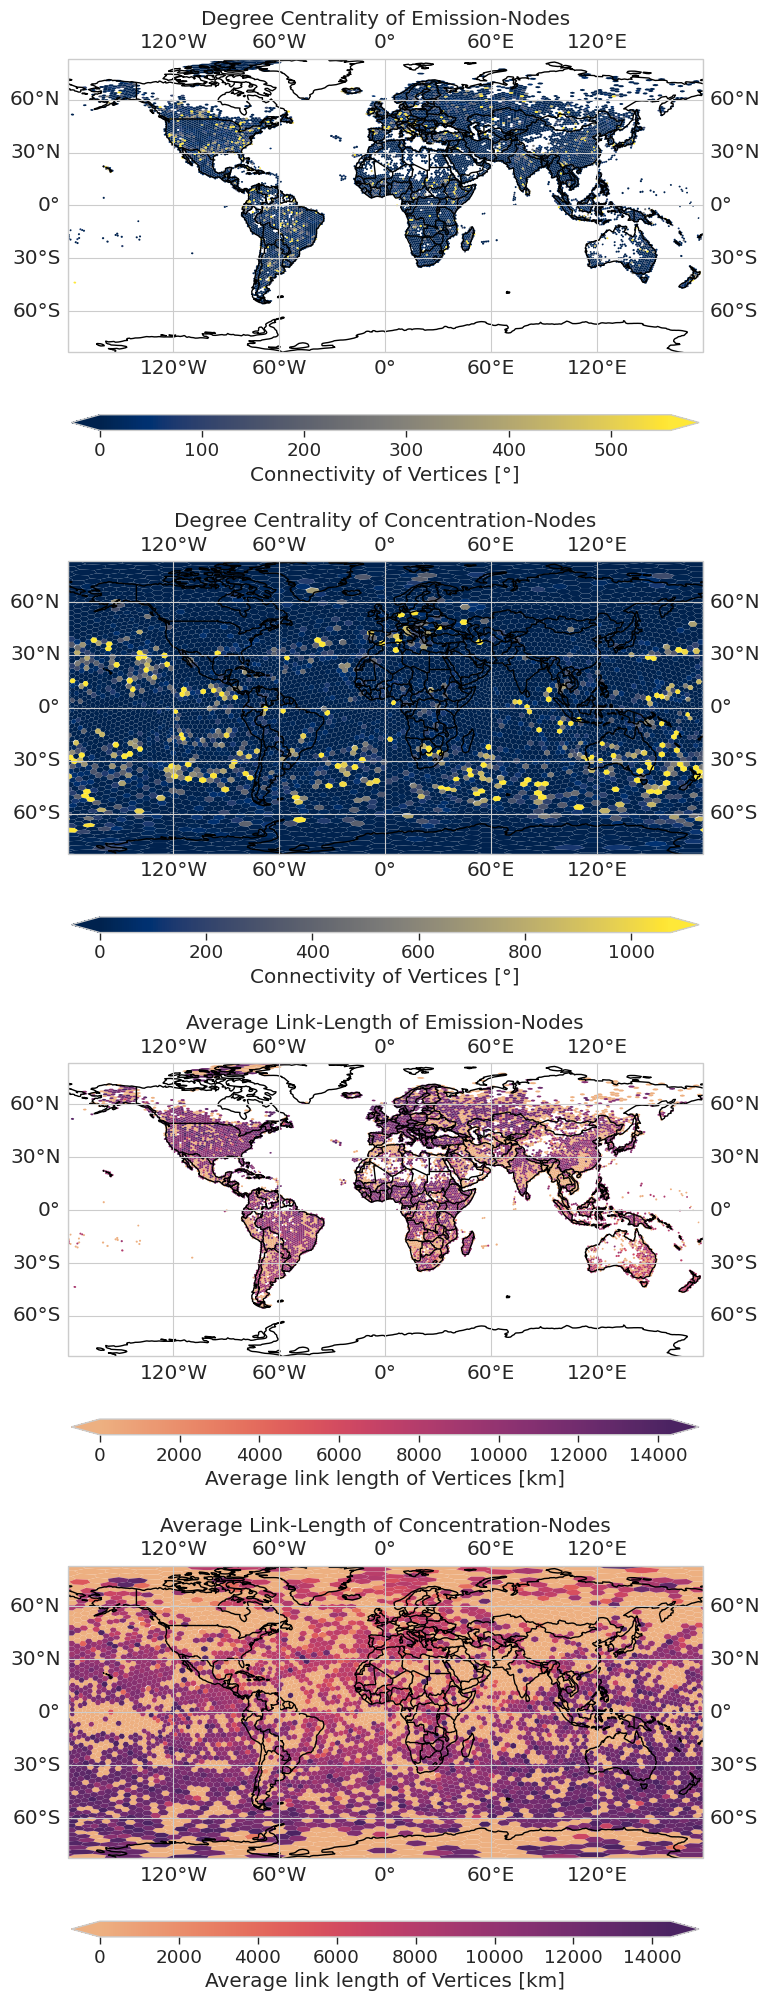

In [56]:
fig, axs = plt.subplots(4, 1,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(9, 25))
axs = axs.flatten()
plot_world_to_axis(deg_graced, axs[0], cmap="cividis")
plot_world_to_axis(deg_airs, axs[1], cmap="cividis")
plot_world_to_axis(avgll_graced, axs[2], cmap="flare")
plot_world_to_axis(avgll_airs, axs[3], cmap="flare")


axs[0].set_title("Degree Centrality of Emission-Nodes")
axs[1].set_title("Degree Centrality of Concentration-Nodes")
axs[2].set_title("Average Link-Length of Emission-Nodes")
axs[3].set_title("Average Link-Length of Concentration-Nodes")

fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network-col.svg", bbox_inches="tight")
fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network-col.jpg", bbox_inches="tight")

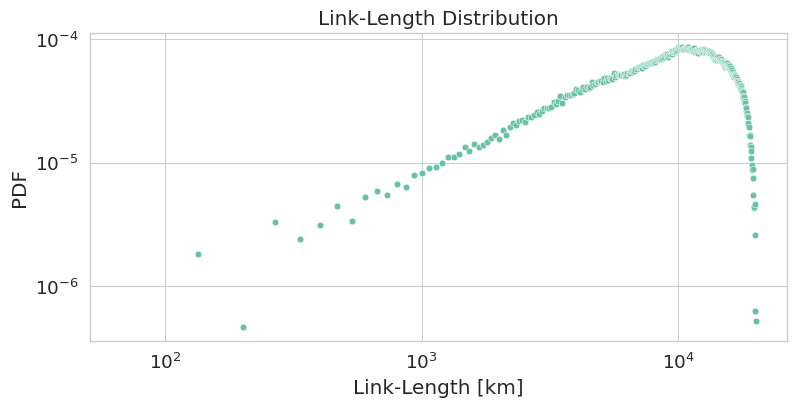

In [66]:
lla = a * ll
ncount, bins = np.histogram(lla.values, bins=300, range=(1, lla.max().item()), density=True)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.scatterplot(x=bins[1:], y=ncount, ax=ax)
ax.set_title("Link-Length Distribution")
ax.set_xlabel("Link-Length [km]")
ax.set_ylabel("PDF")
ax.set_yscale("log")
ax.set_xscale("log")

fig.savefig(FIGURE_PATH / "link-length-distribution.svg", bbox_inches="tight")

In [34]:
del co2_graced, co2_airs, m, a, ll, lla, avgll_graced, deg_graced, avgll_airs, deg_airs, fig, axs, attrs, ax, ax2, bins, ncount

## Data Examples

In [48]:
co2_graced = preprocess_graced_data(hex_res=3)
co2_graced = co2_graced.resample(time='1MS').sum(dim='time').dropna("time", how="all")
co2_graced.attrs = {"long_name": "Human CO2 Emissions", "units": "kgC"}

co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/preprocessed_res3.nc

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

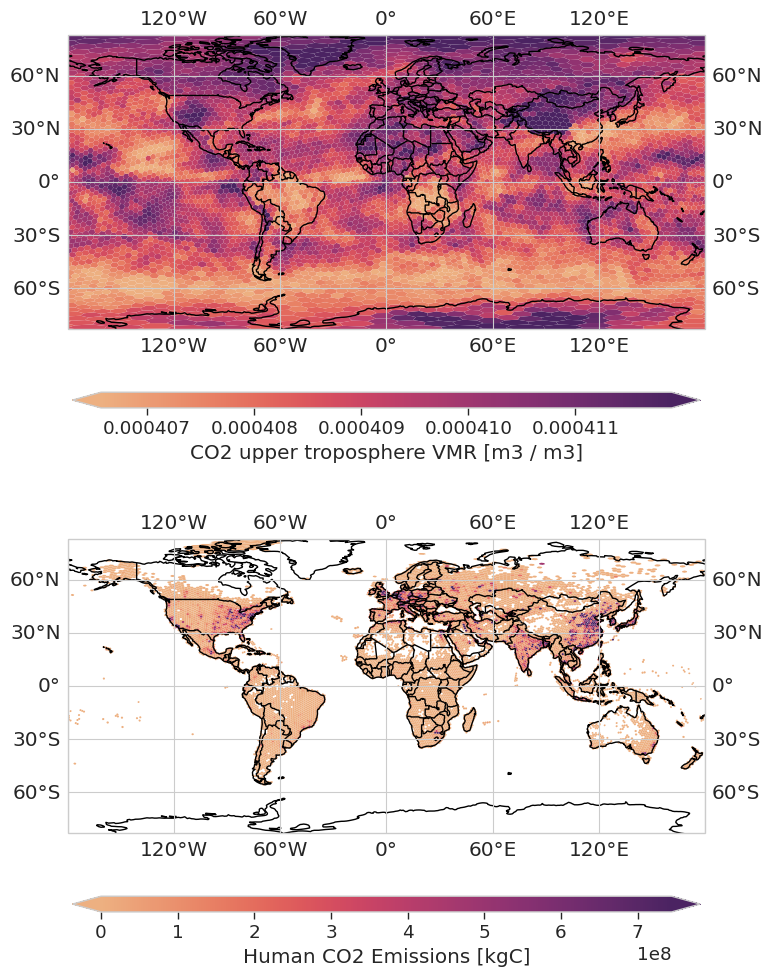

In [49]:
from datetime import datetime
fig, axs = plt.subplots(2, 1, figsize=(9, 12), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},)

axs = axs.flatten()
plot_world_to_axis(co2_airs.sel(time=datetime(2020, 1, 1), method="nearest"), axs[0], cmap="flare")
plot_world_to_axis(co2_graced.sel(time=datetime(2020, 1, 1), method="nearest"), axs[1], cmap="flare")

fig.savefig(FIGURE_PATH / "data.svg", bbox_inches='tight')
fig.savefig(FIGURE_PATH / "data.jpg", bbox_inches='tight')

## AIRS Only

In [57]:
co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
attrs = co2_airs.attrs.copy()
co2_airs.attrs = attrs
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)
co2_airs = (co2_airs - co2_airs.mean(dim="time")) / co2_airs.std(dim="time")
co2_airs.attrs = attrs
co2_airs = anomaly_correction_month(co2_airs)

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

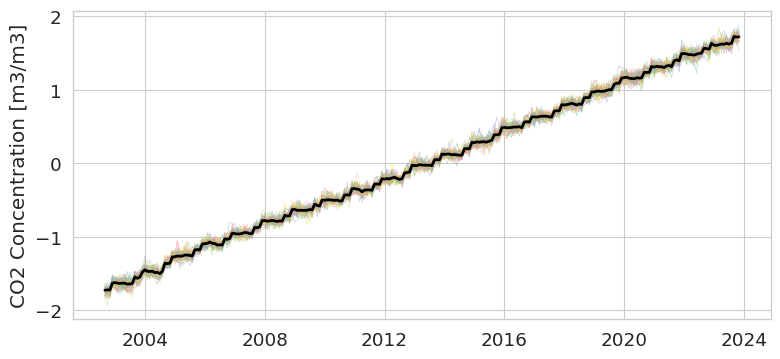

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
palette = sns.color_palette("Set2", 2)

co2_airs.isel(vertex=slice(0, -1, 100)).plot(ax=ax, label="Change in Atmospheric CO2 Concentration", hue="vertex", linewidth=0.5, alpha=0.5)
co2_airs.mean(dim="vertex").plot(ax=ax, label="Change in Atmospheric CO2 Concentration", linewidth=2, c="black")

ax.set_ylabel("CO2 Concentration [m3/m3]")

# Remove the legend
ax.get_legend().remove()

# Remove the title
ax.set_title("")

ax.set_xlabel("")

fig.savefig(FIGURE_PATH / "over-time-airs-only.svg", bbox_inches='tight')

In [59]:
m = mutual_information_matrix(co2_airs)

In [60]:
a = adjacency_matrix(m, rr=0.01)
ll = link_lengths_like(a)
avgll = average_link_length(a, ll)
deg = degrees(a)
bet = betweenness(a, k=1000)

Using a threshold of 3.1324892044067383 for the adjacency matrix

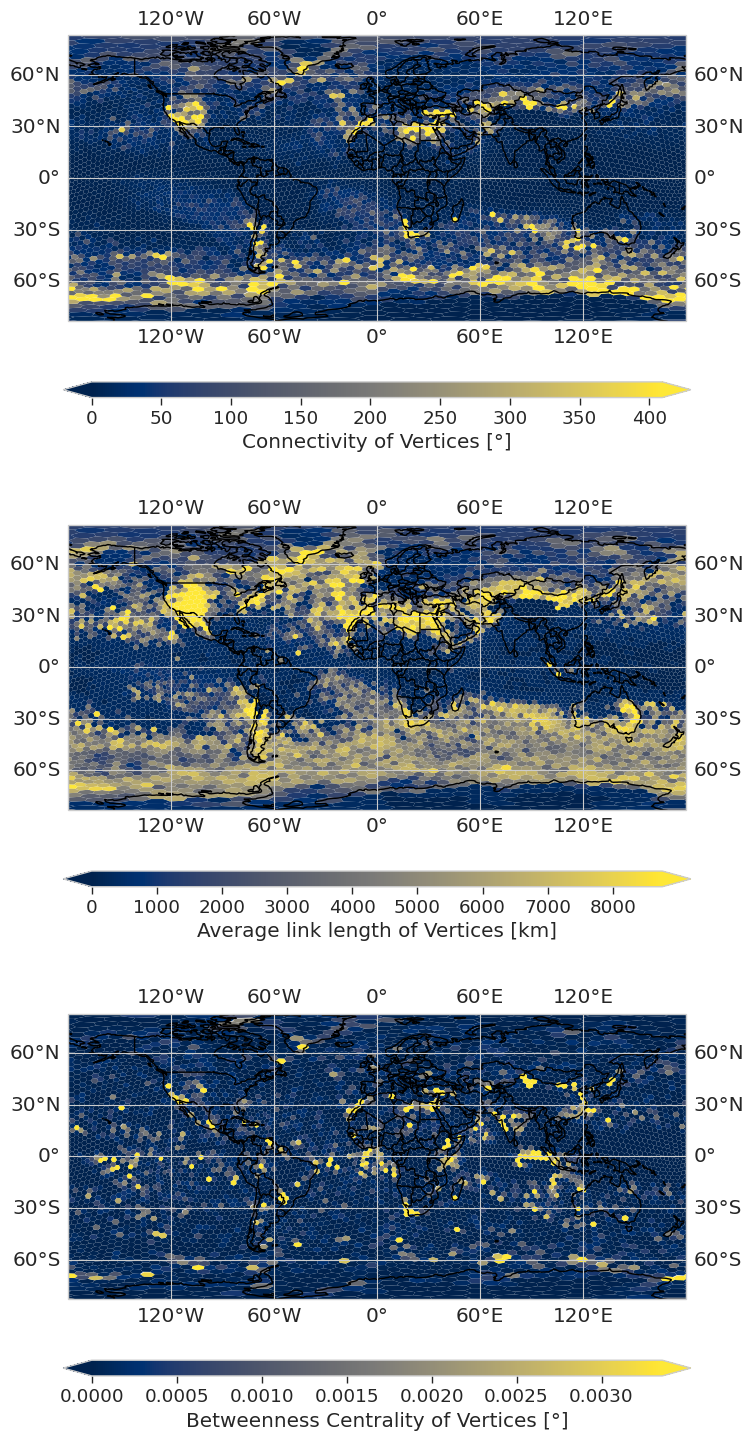

In [61]:
fig, axs = plt.subplots(3, 1,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(9, 18))
axs = axs.flatten()
plot_world_to_axis(deg, axs[0], cmap="cividis")
plot_world_to_axis(avgll, axs[1], cmap="cividis")
plot_world_to_axis(bet, axs[2], cmap="cividis")

fig.savefig(FIGURE_PATH / "concentrations-network-col.svg", bbox_inches='tight')
fig.savefig(FIGURE_PATH / "concentrations-network-col.jpg", bbox_inches='tight')

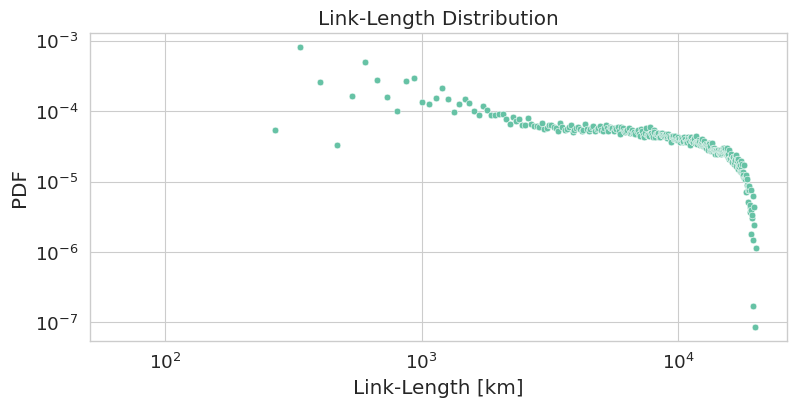

In [62]:
lla = a * ll
ncount, bins = np.histogram(lla.values, bins=300, range=(1, lla.max().item()), density=True)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.scatterplot(x=bins[1:], y=ncount, ax=ax)
ax.set_title("Link-Length Distribution")
ax.set_xlabel("Link-Length [km]")
ax.set_ylabel("PDF")
ax.set_yscale("log")
ax.set_xscale("log")

fig.savefig(FIGURE_PATH / "link-length-distribution_airs_only.svg", bbox_inches='tight')